In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
import matplotlib.patches as mpatches
import cmocean

import glob


import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

# Import Data

### Load in GEOS Chem Runs made from File Creation Notebook, Load in HEMCO Emissions Files

In [2]:
ds= xr.open_dataset('./final_data/ds_NOX_SO2_CH2O_daily.nc4')
ds_seasonal = utils.season_mean(ds)
for p in ['NO2','NOx','NO','SO2','CH2O']:
    ds_seasonal[p].attrs = {'units':'ppb'}



## US, CH2O/NO2 Ratio and Ozone

Using the FNR ratio from Jin et al. 2017 (Evaluating a Space-Based Indicator of Surface Ozone-NOx-
VOC Sensitivity Over Midlatitude Source Regions
and Application to Decadal Trends)

<0.5 = VOC limited

0.5-0.8 = transitional

0.8> = NOx limited

In [4]:

def ratio_plot(ds_seasonal, seasons, species1, species2, models, rows, 
                       columns, figsize, levels,
                       cmap,shrink_cbar,
                       lat_lon, extension = 'max'):
    fig, axes  = plt.subplots(figsize=figsize, nrows = len(models), ncols = len(seasons), subplot_kw={'projection':ccrs.LambertConformal()})
    for idx_s, season in enumerate(seasons):
        for idx_m, model in enumerate(models):
            ax = axes[idx_m, idx_s]
            #make the plot
            q = (ds_seasonal[f'{species1}']/ds_seasonal[f'{species2}']).sel(model_name = model, season = season).plot(ax=ax, #set the axis
                                    levels = np.squeeze(levels), #set the levels for our colorbars
                                   extend=extension,#extend the colorbar in both directions
                                   transform=ccrs.PlateCarree(), #fit data into map
                                    cmap=cmap, add_colorbar = False)  #choose color for our colorbar
            
            ax.add_feature(cfeat.STATES)
            ax.coastlines() #add coastlines
            ax.set_extent(lat_lon) #set a limit on the plot lat and lon
            ax.set_title(''); #title
    for idx_mod, model in enumerate(models):
        axes[idx_mod, 0].annotate(f'{plotting.proper_model_names_dict[model]}', xy=(-.15, 0.05), xycoords = 'axes fraction', fontsize = 14, rotation = 90)
    axes[0,0].set_title(seasons[0], fontsize = 14)
    axes[0,1].set_title(seasons[1], fontsize = 14)
    fig.subplots_adjust(right=0.8)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.3, -0.02, 0.5, 0.03]) # [left, bottom, width, height]
    fig.colorbar(q, cax=cbar_ax, orientation="horizontal")
    cbar_ax.set_xlabel(r'$\frac{CH_2O}{NO_2}$ ratio', fontsize = 14)
    plt.tight_layout()

/tmp/ipykernel_3310943/4039554991.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


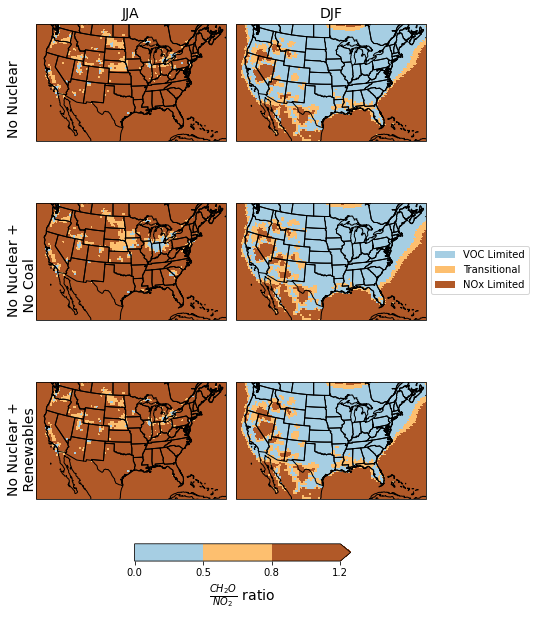

In [9]:
ratio_plot(ds_seasonal = ds_seasonal, species1 = 'CH2O', species2 = 'NO2',  seasons = ['JJA','DJF'], models = ['nonuc_NA','nonuc_coal_NA', 'renew_nonuc_NA'], cmap = plotting.cmap_discrete,
                       rows = 1, columns = 2, levels = [0,.5,.8,1.2], lat_lon = [-120,-70,20,50], shrink_cbar = .7,
                       figsize = [6,8])
VOC_lim = mpatches.Patch(facecolor = plotting.cmap_discrete.colors[0], label = 'VOC Limited')
trans = mpatches.Patch(facecolor = plotting.cmap_discrete.colors[1], label = 'Transitional')
NOX_lim = mpatches.Patch(facecolor = plotting.cmap_discrete.colors[2], label = 'NOx Limited')
plt.legend(handles = [VOC_lim,trans,NOX_lim], loc='upper right', bbox_to_anchor=(1.85, 18.52));
plt.title('')
plt.savefig('./Figures/regime_national_ratio.png', bbox_inches = 'tight', dpi = 150)
